# ETL Example: Create a dimensional model from operational tables

In [ ]:
from pandas import DataFrame
from DATA225utils import make_connection, dataframe_query

In [ ]:
def make_table(table, sql):
    cursor_warehouse.execute(f"DROP TABLE IF EXISTS {table}")
    cursor_warehouse.execute(sql)

In [ ]:
def display_table(table, order_by=''):
    sql = f"SELECT * FROM {table}"
    
    if order_by != '':
        sql = sql + " ORDER BY " + order_by
        
    _, df = dataframe_query(conn_warehouse, sql)    
    return df

## Sources: the operational tables

In [ ]:
conn_sales = make_connection(config_file = 'zagi-sales.ini')
cursor_sales = conn_sales.cursor()

conn_facilities = make_connection(config_file = 'zagi-facilities.ini')
cursor_facilities = conn_facilities.cursor()

conn_customers = make_connection(config_file = 'zagi-customers.ini')
cursor_customers = conn_customers.cursor()

## The dimensional model (data warehouse)

In [ ]:
conn_warehouse = make_connection(config_file = 'zagi-warehouse.ini')
cursor_warehouse = conn_warehouse.cursor()

# Calendar dimension

In [ ]:
sql = ( """
        CREATE TABLE calendar
        (
            calendar_key INT NOT NULL AUTO_INCREMENT,
            full_date DATE,
            day_of_week VARCHAR(9),
            day_of_month INT,
            month INT,
            qtr INT,
            year INT,
            PRIMARY KEY (calendar_key)
        )
        """
      )

make_table('calendar', sql)

#### Source: operational `sales_transaction` table of the Sales Department Database
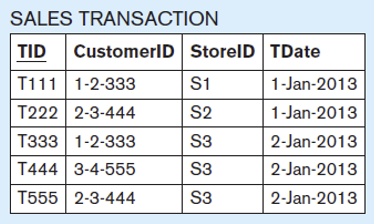

In [ ]:
sql = ( """
        INSERT INTO zagi_warehouse.calendar(full_date, day_of_week, 
                                            day_of_month, month, 
                                            qtr, year)
            SELECT DISTINCT tdate, DAYNAME(tdate), 
                            DAY(tdate), MONTH(tdate), 
                            QUARTER(tdate), YEAR(tdate)
            FROM sales_transaction
        """
      )

cursor_sales.execute(sql)
conn_sales.commit()

display_table('calendar', 'full_date')

# Product dimension

In [ ]:
sql = ( """
        CREATE TABLE product
        (
            product_key INT NOT NULL AUTO_INCREMENT,
            product_id VARCHAR(3),
            product_name VARCHAR(32),
            product_price DOUBLE,
            product_vendor_name VARCHAR(32),
            product_category_name VARCHAR(16),
            PRIMARY KEY(product_key)
        )
        """
      )

make_table('product', sql)

#### Sources: operational `product`, `vendor`, and `category` tables of the Sales Department Database 
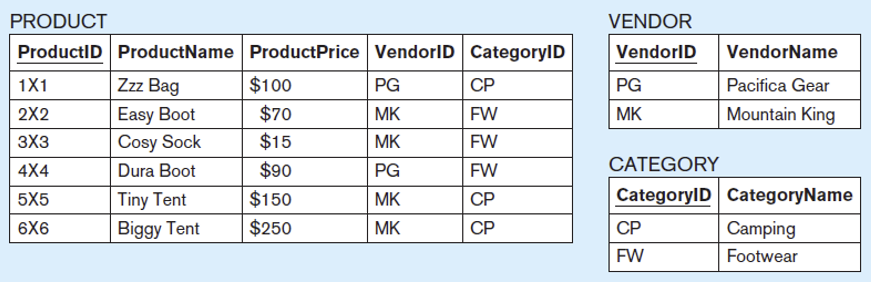

In [ ]:
sql = ( """
        INSERT INTO zagi_warehouse.product(product_id, 
                                           product_name,
                                           product_price,
                                           product_vendor_name,
                                           product_category_name)
            SELECT product_id, product_name, product_price, 
                   vendor_name, category_name
            FROM product, vendor, category
            WHERE product.vendor_id = vendor.vendor_id
            AND   product.category_id = category.category_id
            ORDER BY product_id
        """
      )

cursor_sales.execute(sql)
conn_sales.commit()

display_table('product', 'product_id')

# Store dimension

In [ ]:
sql = ( """
        CREATE TABLE store
        (
            store_key INT NOT NULL AUTO_INCREMENT,
            store_id VARCHAR(2),
            store_zip INT,
            store_region_name VARCHAR(16),
            store_size INT,
            store_c_system VARCHAR(16),
            store_layout VARCHAR(16),
            PRIMARY KEY(store_key)
        )
        """
      )

make_table('store', sql)

#### Sources:
- #### operational `store` and `region` tables from the Sales Department Database
- #### operational `checkout_system`, `store`, and `layout` tables from the Facilities Department Database
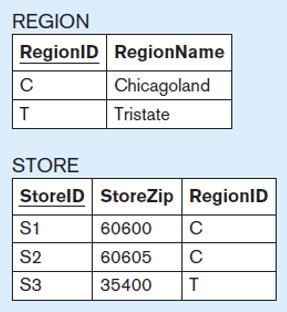
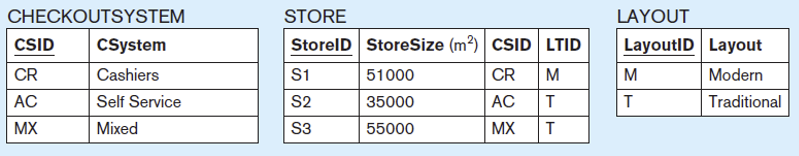

In [ ]:
sql = ( """
        INSERT INTO zagi_warehouse.store(store_id, store_zip, 
                                         store_region_name,
                                         store_size,
                                         store_c_system,
                                         store_layout)
            SELECT zagi_sales.store.store_id, 
                   zagi_sales.store.store_zip, 
                   zagi_sales.region.region_name,
                   zagi_facilities.store.store_size, 
                   zagi_facilities.checkout_system.c_system, 
                   zagi_facilities.layout.layout
            FROM zagi_sales.store, zagi_sales.region,
                 zagi_facilities.checkout_system,
                 zagi_facilities.store,
                 zagi_facilities.layout
            WHERE zagi_sales.store.region_id      = zagi_sales.region.region_id
            AND   zagi_sales.store.store_id       = zagi_facilities.store.store_id
            AND   zagi_facilities.store.cs_id     = zagi_facilities.checkout_system.cs_id
            AND   zagi_facilities.store.layout_id = zagi_facilities.layout.layout_id
            ORDER BY store_id
        """
      )

cursor_sales.execute(sql)
conn_sales.commit()

display_table('store', 'store_id')

# Customer dimension

In [ ]:
sql = ( """
        CREATE TABLE customer
        (
            customer_key INT NOT NULL AUTO_INCREMENT,
            customer_id VARCHAR(7),
            customer_name VARCHAR(32),
            customer_zip INT,
            customer_gender VARCHAR(6),
            customer_marital_status VARCHAR(7),
            customer_education_level VARCHAR(16),
            customer_credit_score INT,
            PRIMARY KEY(customer_key)
        )
        """
      )

make_table('customer', sql)

#### Source: customer demographic data from a market research company
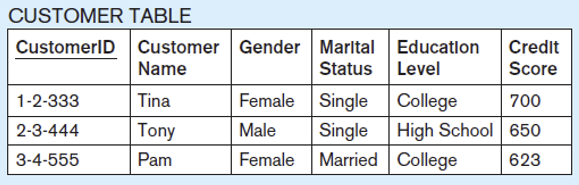

In [ ]:
sql = ( """
        INSERT INTO zagi_warehouse.customer(customer_id, customer_name, 
                                            customer_zip, customer_gender,
                                            customer_marital_status,
                                            customer_education_level,
                                            customer_credit_score)
            SELECT zagi_sales.customer.customer_id, 
                   zagi_sales.customer.customer_name, 
                   zagi_sales.customer.customer_zip,
                   zagi_customers.customer.gender,
                   zagi_customers.customer.marital_status,
                   zagi_customers.customer.education_level,
                   zagi_customers.customer.credit_score
            FROM zagi_sales.customer, zagi_customers.customer
            WHERE zagi_sales.customer.customer_id = zagi_customers.customer.customer_id
            ORDER BY customer_id
        """
      )

cursor_sales.execute(sql)
conn_sales.commit()

display_table('customer', 'customer_id')

# Sales fact table

In [ ]:
sql = ( """
        CREATE TABLE sales
        (
            calendar_key INT,
            store_key INT,
            product_key INT,
            customer_key INT,
            tid VARCHAR(8),
            time_of_day TIME,
            dollars_sold DOUBLE,
            units_sold INT,
            PRIMARY KEY(product_key, tid)
        )
        """
      )

make_table('sales', sql)

#### Sources: operational `product`, `customer`, `store`, `sales_transaction`, and `sold_via` tables from the Sales Department Database
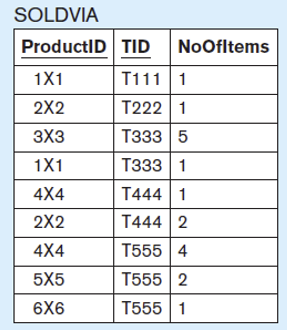

In [ ]:
sql = ( """
        INSERT INTO zagi_warehouse.sales(calendar_key, store_key,
                                         product_key, customer_key,
                                         tid, 
                                         dollars_sold, units_sold)
            SELECT 	calendar_key, store_key, product_key, customer_key, 
                    zagi_sales.sales_transaction.tid, 
                    zagi_sales.sold_via.no_of_items*zagi_sales.product.product_price AS dollars_sold, 
                    zagi_sales.sold_via.no_of_items AS units_sold
            FROM zagi_warehouse.calendar, zagi_warehouse.store, 
                 zagi_warehouse.product, zagi_warehouse.customer,
                 zagi_sales.product, zagi_sales.customer, zagi_sales.store, 
                 zagi_sales.sales_transaction, zagi_sales.sold_via
            WHERE zagi_sales.sales_transaction.tid          = zagi_sales.sold_via.tid
            AND   zagi_sales.sales_transaction.customer_id  = zagi_sales.customer.customer_id
            AND   zagi_sales.sales_transaction.store_id     = zagi_sales.store.store_id
            AND   zagi_sales.sold_via.product_id            = zagi_sales.product.product_id
            AND   zagi_warehouse.calendar.full_date         = zagi_sales.sales_transaction.tdate
            AND   zagi_warehouse.store.store_id             = zagi_sales.store.store_id
            AND   zagi_warehouse.product.product_id         = zagi_sales.sold_via.product_id
            AND   zagi_warehouse.customer.customer_id       = zagi_sales.sales_transaction.customer_id
            ORDER BY calendar_key, store_key
        """
      )

cursor_sales.execute(sql)
conn_sales.commit()

display_table('sales', 'tid')

In [ ]:
cursor_sales.close()
conn_sales.close()

cursor_facilities.close()
conn_facilities.close()

cursor_customers.close()
conn_customers.close()

cursor_warehouse.close()
conn_warehouse.close()

#### (c) Copyright 2023 by Ronald Mak